In [1]:
# =============================================================================
# # 1. SETUP: IMPORTING LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set a visual style
sns.set_style("whitegrid")

--- First 5 Rows of the Time Series ---
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


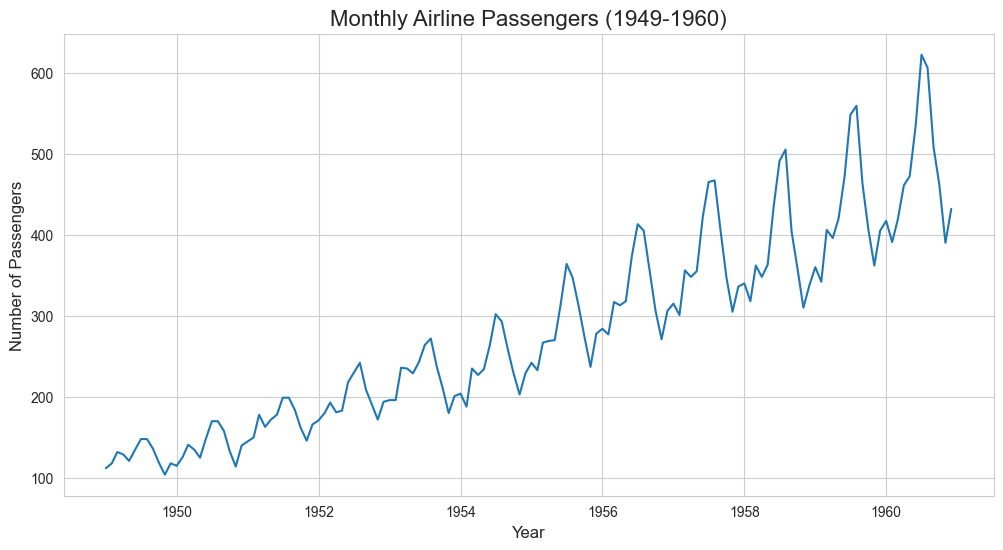

In [2]:
# =============================================================================
# # 2. DATA LOADING AND PREPROCESSING
# =============================================================================
try:
    # Load the dataset. The key is to parse the 'Month' column as dates.
    df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
except FileNotFoundError:
    print("Error: 'AirPassengers.csv' not found. Please download it from Kaggle.")
    exit()

# Rename the column for easier access
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

print("--- First 5 Rows of the Time Series ---")
print(df.head())

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'])
plt.title('Monthly Airline Passengers (1949-1960)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.show()
# Insight: We can clearly see an upward trend and a yearly seasonal pattern.

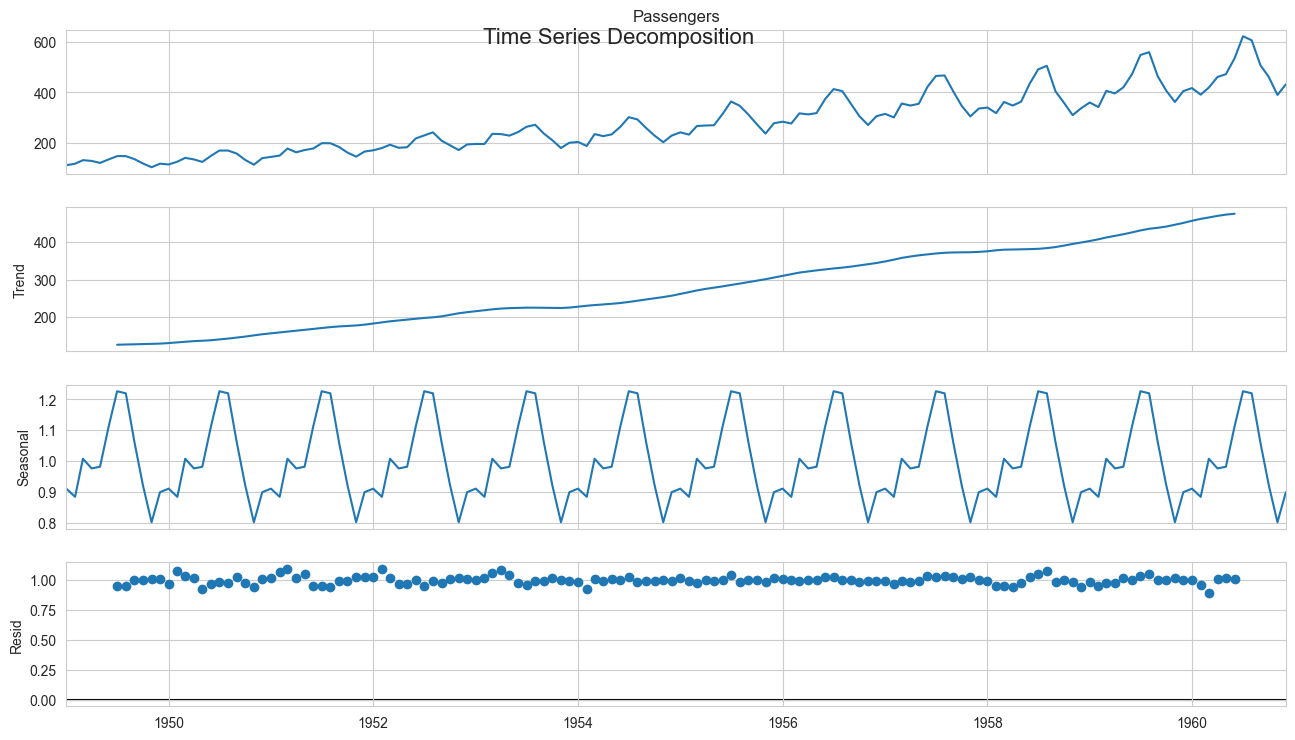

In [3]:
# =============================================================================
# # 3. TIME SERIES DECOMPOSITION
# =============================================================================
# Decompose the series to see its individual components.
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Time Series Decomposition', y=0.93, fontsize=16)
plt.savefig('time_series_decomposition.png')
plt.show()

In [4]:
# =============================================================================
# # 4. TRAIN-TEST SPLIT AND MODEL TRAINING
# =============================================================================
# For time series, we split the data chronologically.
# Let's train on data up to the end of 1959 and test on 1960.
train_data = df.loc[:'1959-12-31']
test_data = df.loc['1960-01-01':]

# --- Train the ARIMA Model ---
# ARIMA(p, d, q)
# p: order of the autoregressive (AR) part
# d: degree of first differencing (I part)
# q: order of the moving average (MA) part
# These orders are typically found through statistical analysis (e.g., ACF/PACF plots),
# but we'll use common values for this dataset for simplicity.
model = ARIMA(train_data['Passengers'], order=(5, 1, 0))
model_fit = model.fit()

print("--- ARIMA Model Summary ---")
print(model_fit.summary())

C:\Users\RIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


--- ARIMA Model Summary ---
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -621.898
Date:                Mon, 08 Sep 2025   AIC                           1255.796
Time:                        09:52:56   BIC                           1273.047
Sample:                    01-01-1949   HQIC                          1262.806
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3005      0.101      2.986      0.003       0.103       0.498
ar.L2         -0.1903      0.096     -1.972      0.049      -0.379      -0.001
ar.L3         -0.0961   

C:\Users\RIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


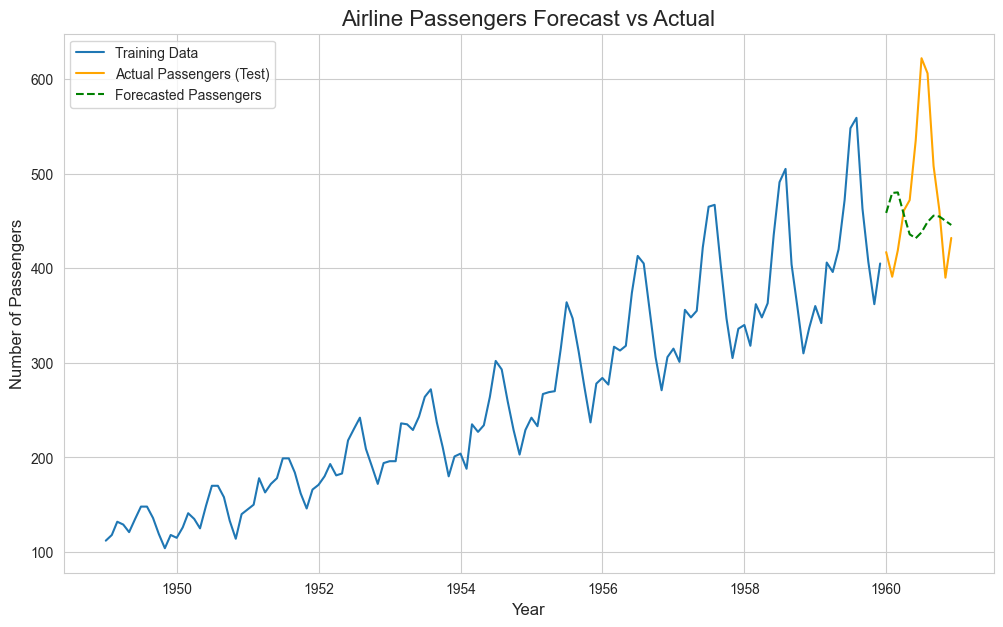

Root Mean Squared Error (RMSE) of the forecast: 86.81


In [5]:
# =============================================================================
# # 5. FORECASTING AND VISUALIZATION
# =============================================================================
# Forecast the values for the test period
start_index = len(train_data)
end_index = start_index + len(test_data) - 1
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')
forecast.index = test_data.index

# --- Visualize the Forecast ---
plt.figure(figsize=(12, 7))
plt.plot(train_data['Passengers'], label='Training Data')
plt.plot(test_data['Passengers'], label='Actual Passengers (Test)', color='orange')
plt.plot(forecast, label='Forecasted Passengers', color='green', linestyle='--')
plt.title('Airline Passengers Forecast vs Actual', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend()
plt.savefig('forecast_plot.png') # Save this plot for LinkedIn
plt.show()

# Evaluate the forecast
rmse = np.sqrt(mean_squared_error(test_data['Passengers'], forecast))
print(f"Root Mean Squared Error (RMSE) of the forecast: {rmse:.2f}")